In [ ]:
'''
Documentation
Steps involve in code-
4. Declearing Train and Test dataset
5. Compile and fit.transform the model
6. Save the model in  .hdf5/ .h5 formate.
7. Look on the accuracy and loss function
8. Try on the test dataset and observation (accuracy and loss using various method)

This code can be used to perform semantic segmentation of aerial / satellite 
images, especially the dataset from landcover.ai

You can use any U-net but this code demonstrates the use of pretrained encoder 
in the U-net - available as part of segmentation models library. 

Use the landcover_prepare_data.py to prepare your data. 
e.g., divide images to smaller patches, save only the patches with real labels, split to train and val. 

'''

In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random

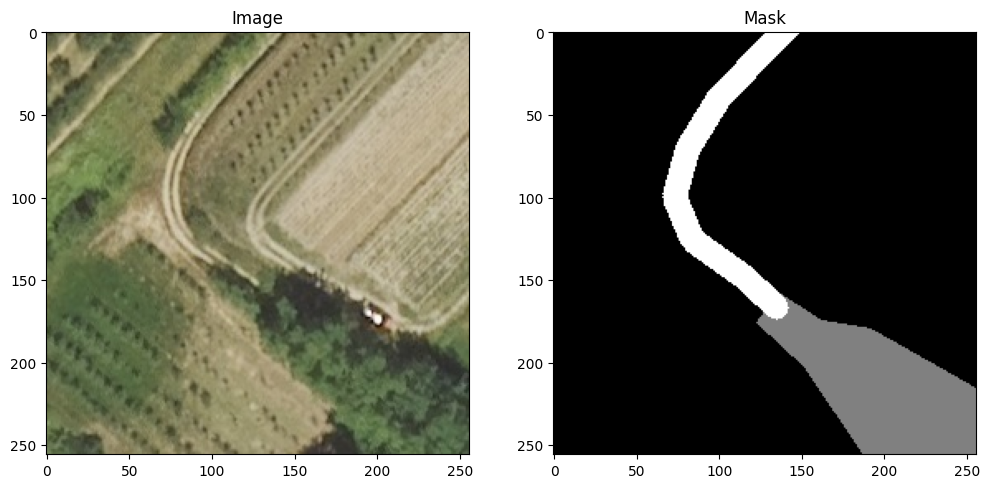

In [2]:
#Getting an dunderstanding few random images
train_img_dir = "landcover.ai.v1/data_for_keras_aug/train_images/train/" #images
train_mask_dir = "landcover.ai.v1/data_for_keras_aug/train_masks/train/" #mask respective

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))


img_num = random.randint(0, num_images-1) #taking the random images to show the respective masks

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)
#repesenting the images and respective mask side by side
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()


In [ ]:
seed=24
batch_size= 16
n_classes=4

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder #check the labelEncoder

#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

#Define a function to perform additional preprocessing after datagen.
#For example, scale images, convert masks to categorical, etc. 
def preprocess_data(img, mask, num_class): 
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    mask = to_categorical(mask, num_classes = num_class)                                                        
    return (img,mask)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None, #no classification type code
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    print(train_generator)
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class) #############
        yield (img, mask)


train_img_path = "landcover.ai.v1/data_for_keras_aug/train_images/"
train_mask_path = "landcover.ai.v1/data_for_keras_aug/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=5) #to remove the index4 out of bound use 5 instead of 4

val_img_path = "landcover.ai.v1/data_for_keras_aug/val_images/"
val_mask_path = "landcover.ai.v1/data_for_keras_aug/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=5) #to remove the index4 out of bound use 5 instead of 4

In [ ]:
x, y = train_img_gen.__next__()

for i in range(0,3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [ ]:
x_val, y_val = val_img_gen.__next__()

for i in range(0,3):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [ ]:
#Define the model metrcis and load model. 

num_train_imgs = len(os.listdir('landcover.ai.v1/data_for_keras_aug/train_images/train/'))
num_val_images = len(os.listdir('landcover.ai.v1/data_for_keras_aug/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size


IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

n_classes=5 #as we had given the size of the 

# Define Model

In [ ]:

model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='softmax')
model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])
#iou - intersection over union score, you can also use the 
#Other losses to try: categorical_focal_dice_loss, cce_jaccard_loss, cce_dice_loss, categorical_focal_loss

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['metrics']) #["accuracy"]
print(model.summary())
print(model.input_shape) #(256,256,3) as per the expectation

In [ ]:
history=model.fit(train_img_gen,
                  steps_per_epoch=steps_per_epoch,
                  epochs=2,
                  verbose=1,
                  validation_data=val_img_gen,
                  validation_steps=val_steps_per_epoch)

In [ ]:
model.save('landcover_2_epochs_RESNET_backbone_batch16.hdf5')

# Model Evaluation using Model and various graphical

In [ ]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

# Generating the result using Model

In [ ]:
from keras.models import load_model
model = load_model("landcover_2_epochs_RESNET_backbone_batch16.hdf5", compile=False)

#batch_size=32 #Check IoU for a batch of images

#Test generator using validation data.

test_image_batch, test_mask_batch = val_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 5
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
#View a few images, masks and corresponding predictions. 
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()